In [24]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt

##Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg, 1988; the last stress period use 25% less recharge and 25% more pumping.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 13 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

  ...load method not completed. default nwt file created.


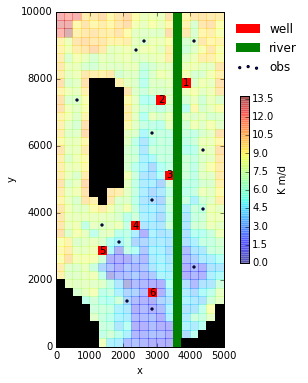

In [32]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.dis.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.dis.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

The plot shows the Freyberg (1988) model domain.  The colorflood is the hydraulic conductivity ($\frac{m}{d}$).  Red and green cells coorespond to well-type and river-type boundary conditions. Blue dots the locations of water levels used for calibration.

##Using `pyemu`

In [33]:
import pyemu

First create a linear_analysis object.  We will use `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [34]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))
la = pyemu.Schur(jco=jco, forecasts=pst.pestpp_options["forecasts"].split(','),verbose=False)
print("observations,parameters in jacobian:",la.jco.shape)


observations,parameters in jacobian: (2115, 761)


##Parameter uncertainty analysis
Let's calculate and save the posterior parameter covariance matrix:

In [35]:
la.posterior_parameter.to_ascii(jco+"_post.cov")

You can open this file in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated method only require access:


In [36]:
la.posterior_parameter.to_dataframe().sort().sort(axis=1).iloc[0:3,0:3] #look so nice in the notebook

,hkr00c00,hkr00c01,hkr00c02
hkr00c00,2.499965e-01,-8.837002e-07,-0.000005
hkr00c01,-8.837002e-07,2.499910e-01,-0.000021
hkr00c02,-4.635569e-06,-2.085084e-05,0.249947


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 761 parameters. The ``.get_parameters_summary()`` method is the easy way:

,percent_reduction,post_var,prior_var
rch_1,49.884568,0.000238,0.000475
hkr30c15,31.278933,0.171803,0.250000
hkr03c11,26.494859,0.183763,0.250000
hkr34c09,25.096673,0.187258,0.250000
hkr04c10,24.712660,0.188218,0.250000
hkr22c12,22.009284,0.194977,0.250000
hkr25c06,21.114649,0.197213,0.250000
hkr35c12,19.869449,0.200326,0.250000
hkr35c10,18.608329,0.203479,0.250000
hkr04c16,17.240172,0.206900,0.250000


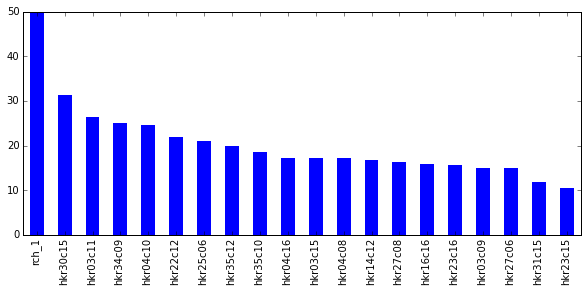

In [37]:
#get the parameter uncertainty dataframe and sort it
par_sum = la.get_parameter_summary().sort("percent_reduction",ascending=False)
#make a bar plot of the percent reduction ((prior - posterior) / prior) for the first 20 parameters 
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 entries
par_sum.iloc[0:10,:]

We can see that calibrating the model to the 13 water levels reduces the uncertainty of the calibration period recharge parameter (`rch_0`) by 50%.  Additionally, the hydraulic conductivity of many model cell is also reduced.  Now lets look at the other end of the parameter uncertainty summary.  Note that calling ``get_parameter_summary()`` again results in no additional computation 

,percent_reduction,post_var,prior_var
hkr39c14,0,0.250000,0.250000
hkr01c19,0,0.250000,0.250000
hkr00c19,0,0.250000,0.250000
wf6_2,0,0.014228,0.014228
wf5_2,0,0.014228,0.014228
wf3_2,0,0.014228,0.014228
wf2_2,0,0.014228,0.014228
wf1_2,0,0.014228,0.014228
sy,0,0.250000,0.250000
ss,0,0.250000,0.250000


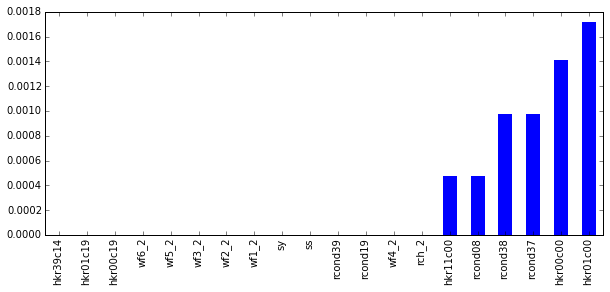

In [38]:
# sort in increasing order
par_sum = la.get_parameter_summary().sort("percent_reduction")
# plot the first 20
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 
par_sum.iloc[0:10,:]

We see that several parameters are uneffected by calibration - these are mostly parameters that represent forecast period uncertainty (parameters that end with ```_2```), but there are also some hydraulic conductivities that are uninformed by the 13 water level observations

We can also make a map of uncertainty reduction for the hydraulic conductivity parameters using some ```flopy``` action

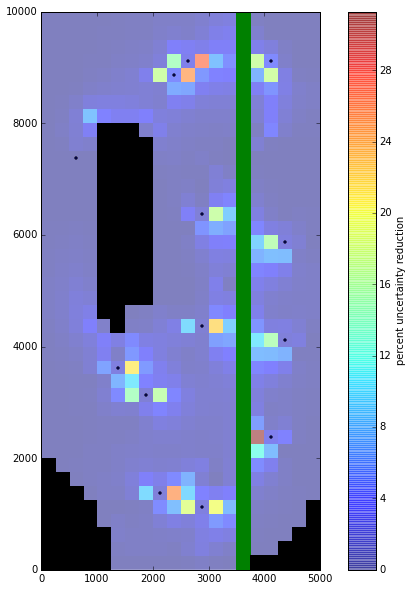

In [39]:
hk_pars = par_sum.loc[par_sum.groupby(lambda x:"hk" in x).groups[True],:]
hk_pars.loc[:,"names"] = hk_pars.index
names = hk_pars.names
hk_pars.loc[:,"i"] = names.apply(lambda x: int(x[3:5]))
hk_pars.loc[:,"j"] = names.apply(lambda x: int(x[6:8]))
unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
for i,j,unc in zip(hk_pars.i,hk_pars.j,hk_pars.percent_reduction):
    unc_array[i,j] = unc 
unc_array[unc_array == -1] = np.NaN

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
cb = ax.imshow(unc_array,interpolation="none",alpha=0.5,extent=ml.dis.sr.get_extent())
plt.colorbar(cb,label="percent uncertainty reduction")
#ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.')



As you might expect, most of the information in the observations is flowing to the hydraulic conductivity parameters near observations themselves.

##Forecast uncertainty
Now let's examine the prior and posterior variance of the forecasts:

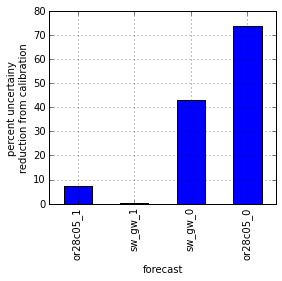

In [48]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax = la.get_forecast_summary().percent_reduction.plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()
plt.savefig("forecast_sum.pdf")

Notice the spread on the uncertainty reduction: some forecasts benefit more from calibration than others.  For example, ```or28c05_0```, the calibration-period water level forecast, benefits from calibration since its uncertainty is reduced by 75%, while ```sw_gw_1```, the forecast-period surface-water groundwater exchange forecast does not benefit from calibration - its uncertainty is unchanged by calibration

##Data worth
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases

```importance_of_obesrvation_groups()``` is a thin wrapper that calls the underlying ```importance_of_observations()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  

This call will test all of the non-forecast observations in the PEST data set to see which ones are most important 


```base``` row are the results of Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for each of the 13 water level obseravtions (e.g. or17c17 is the observation in row 18 column 18) show how much forecast uncertainty increases when that particular observation is not used in history matching.  So we see again that each forecast depends of the observations differently

A water-level obseravtion for each active model cell was also "carried" in the pest control file.  This means we can run this same analysis to find the best next place to collect a new water level.  This takes a little longer because it is rerunning the schur's complement calculations many times, so here we'll just use the 13 observations:

In [11]:
obs_dict = dict(zip(pst.nnz_obs_names,pst.nnz_obs_names))
print(len(obs_dict))

13


In [12]:
df_worth= la.get_importance_dataframe(obs_dict)

In [13]:
df_worth

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
base,0.104901,1.349353,45266.951772,620442.618112
or30c16_0,0.104913,1.349405,45486.605342,620449.437222
or04c09_0,0.104901,1.349380,45376.309284,620446.560354
or14c11_0,0.104914,1.349704,46344.283861,620478.500585
or25c05_0,0.139213,1.361276,45859.283606,620452.111319
or22c11_0,0.104907,1.349639,45438.014277,620456.475235
or03c10_0,0.104901,1.349353,45267.631429,620444.798848
or34c08_0,0.105463,1.349361,45546.665830,620550.423439
or10c02_0,0.106080,1.349520,50438.518215,620553.778164
or03c16_0,0.104919,1.349542,46517.650426,620459.380623


In [14]:
# a little processing of df_worth
df_base = df_worth.loc["base",:].copy()
df_imax = df_worth.apply(lambda x:x-df_base,axis=1).idxmax()
df_max = 100.0 * (df_worth.apply(lambda x:x-df_base,axis=1).max() / df_base)
df_par = pd.DataFrame([df_imax,df_max],index=["most important observation","percent increase when left out"])
df_par

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
most important observation,or27c07_0,or27c07_0,or10c02_0,or10c02_0
percent increase when left out,45.90741,2.160142,11.4246,0.01791625


We see that observation ```or27c07_0``` is the most important for the water level forecasts (```or28c05_0``` and ```or28c05_1```), while observation ```or10c02_0``` is the most important for the surface water groundwater exchange forecasts (```sw_gw_0``` an ```sw_gw_1```)

##parameter contribution to uncertainty
Lets look at which parameters are contributing most to forecast uncertainty.  for demostration purposes, lets group the parameters by parameter group name.

In [15]:
df = la.get_contribution_dataframe_groups()
df

or28c05_0                          or28c05_1                      \
        percent_reduce      post     prior percent_reduce      post     prior   
base         73.841701  0.104901  0.401023       7.343810  1.349353  1.456301   
rch          65.768008  0.104280  0.304629      13.592741  0.692060  0.800928   
welflux      73.841291  0.104642  0.400026       7.641788  1.292918  1.399895   
rcond        73.841795  0.104897  0.401010       7.344041  1.349350  1.456301   
storage      73.841701  0.104901  0.401023      11.868901  0.794129  0.901077   
hk           99.749734  0.000244  0.097405       0.419918  1.261683  1.267003   

               sw_gw_0                                    sw_gw_1  \
        percent_reduce          post         prior percent_reduce   
base         43.156275  45266.951772  79634.034592       0.110646   
rch          12.301504   3900.047023   4447.108198       0.168021   
welflux      43.743394  43617.767683  77533.592215       0.130449   
rcond        43.177485  45244.828949  79624.827130       0.110633   
storage      43.156275  45266.951772  79634.034592       0.129891   
hk           98.743279    971.402233  77296.576233       0.134450   

                                       
                  post          prior  
base     620442.618112  621129.872236  
rch      185502.204821  185814.411201  
welflux  527751.898672  528441.245961  
rcond    620437.848843  621125.016889  
storage  528412.812692  529100.066815  
hk       619205.103398  620038.748077

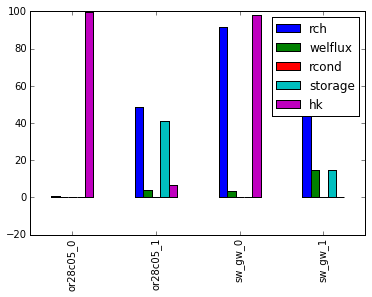

In [16]:
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
df_percent.T.plot(kind="bar")

We see some interesting results here.  The sw-gw flux during calibration (sw_gw_0) is influenced by both recharge and hk uncertainty, but the forecast period sw-gw flux is influenced most by forecast period recharge uncertainty.  unfortunately, model calibration does not tell us about forecast period forcing, so calibration doesn't help with this forecast.  For the water level forecasts (```or28c05_0 and or28c05_1```), the results are similar: the forecast of water level at the end of the calibration period benefits most from hk knowledge, while the forecast period water level is most by recharge and storage.  Let's do this same analysis, but now group the parameters differently:

In [17]:
pnames = la.pst.par_names
fore_names = [pname for pname in pnames if pname.endswith("_2")]
props = [pname for pname in pnames if pname[:2] in ["hk","ss","sy","rc"] and "rch" not in pname]
cal_names = [pname for pname in pnames if pname.endswith("_1")]
pdict = {'forecast forcing':fore_names,"properties":props,"calibration forcing":cal_names}
df = la.get_contribution_dataframe(pdict)

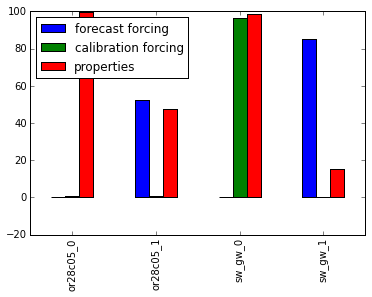

In [18]:
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
df_percent.T.plot(kind="bar")